# Query an API

This notebook has code to fetch some data from the [National Museum of Australia API](https://github.com/NationalMuseumAustralia/Collection-API/wiki/Getting-started) and from the beta version of the [Australian Bureau of Statistics API](https://api.gov.au/service/715cdfd0-4742-402e-8729-086a7fd42a51).

In each case, we'll use the examples included in the documentation for the API -- in the first case, looking at museum materials [made of bark](https://github.com/NationalMuseumAustralia/Collection-API/wiki/Getting-started#access), and in the second case, sussing out how many litres of alcohol Australians drink annually [via mid-strength beer](https://api.gov.au/service/715cdfd0-4742-402e-8729-086a7fd42a51/Worked%20Examples) -- but implement them as Python code.

In [2]:
# used to fetch the API keys stored as environment variables
import os

# used to make the actual API calls
import requests
# used to show how to feed the data into a dataframe for analysis
import pandas as pd

## National Museum API

In [3]:
# all endpoints begin with this URL
api_base_route_mus = 'https://data.nma.gov.au'

In [4]:
# let's look at the /object endpoint, following the example in the docs
# using f-strings here to build the URL: https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings
endpoint_mus = f'{api_base_route_mus}/object'

In [5]:
# with requests, you can pass URL parameters as a dictionary
params = {
    'title': 'bark'
}

In [6]:
# make the request to the endpoint using those parameters
# and store the results in a variable
req_mus = requests.get(
    endpoint_mus,
    params=params
)

In [7]:
# use requests' built-in JSON encoder/decoder rather than manually converting the string to JSON
# https://docs.python-requests.org/en/master/user/quickstart/#json-response-content
data_mus = req_mus.json()

In [ ]:
print(data_mus)

### Next steps

We've got the data stored in a variable. Now what? Depends entirely on your project! Maybe this API call is just a small chunk of a larger project that involves filtering the results to find something interesting, then Tweeting that out (which would involve interacting with the Twitter API) or sending a Slack message to your coworkers (which would involve interacting with the Slack API) or sending an email (Gmail API); or maybe you're doing a data analysis project, so you'd feed these results into a pandas dataframe; or maybe you're just getting a cut of the data to share with a colleague, in which case you'd need to write this data to file; etc.

For our purposes today, let's just write these results to file. Because the `json()` method converted the string of JSON into a Python data structure, we'll need to use the `.text` attribute instead when writing to file.

In [10]:
# in a with block, open a file in write mode
# https://docs.python.org/3/library/functions.html#open
with open('aus-nat-museum-bark.json', 'w') as outfile:
    outfile.write(req_mus.text)

## Australian Bureau of Statistics API (beta)

In [11]:
# grab a reference to the API key stored on the computer
api_key_abs = os.environ.get('AUS_ABS_API_KEY')

In [12]:
# print(api_key_abs)

In [13]:
# all endpoints start with this URL
api_base_route_abs = 'https://api.data.abs.gov.au'

In [14]:
# to authenticate with our API key, add to the headers
headers = {
    'x-api-key': api_key_abs
}

In [15]:
# the actual endpoint we'll query -- the lengthy explanation for how
# we arrived here is described in the documentation
endpoint_abs = f'{api_base_route_abs}/data/ALC/1.2.1.4.A'

In [16]:
# a parameter to tell the server that we want JSON instead
# of the default XML response
params = {
    'format': 'jsondata'
}

In [17]:
# send the request with the authentication headers
# and the parameters
req_abs = requests.get(
    endpoint_abs,
    headers=headers,
    params=params
)

In [18]:
# use requests' built-in JSON encoder/decoder rather than manually converting the string to JSON
data_abs = req_abs.json()

### ⚠️ All of the code that follows will probably confuse you, and that's OK!

The way ABS has structured its API is ... less than friendly to end users -- I'm guessing partly because of the complexity of the back-end data? -- and as a result you have to do quite a bit of speleunking in the JSON to find (and reshape) the target data.

Two more advanced techniques we use here are:
- [List comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions), a way to operate on an iterable data structure (like a list) and store the results in a variable (see also [the relevant section in this notebook](Data%20types%20and%20basic%20syntax.ipynb#List-comprehensions))
- [The `zip()` function](https://docs.python.org/3.3/library/functions.html#zip), which we're using here to combine two lists like a zipper

In [19]:
# dive into the JSON to retrieve the actual data points
observations = data_abs['data']['dataSets'][0]['series']['0:0:0:0:0']['observations']

In [20]:
# use a list comprehension to extract just the numeric values
annual_data = [observations[x][0] for x in observations]

In [21]:
# dive into a different part of the JSON to get the time values
dates = data_abs['data']['structure']['dimensions']['observation'][0]['values']

In [22]:
# use a list comprehension to grab the year as a number
years = [int(x['name']) for x in dates]

In [23]:
# combine the two lists
years_data = list(zip(years, annual_data))

In [24]:
years_data

[(2001, 0.46),
 (2002, 0.45),
 (2003, 0.49),
 (2004, 0.54),
 (2005, 0.52),
 (2006, 0.54),
 (2007, 0.56),
 (2008, 0.56),
 (2009, 0.57),
 (2010, 0.57),
 (2011, 0.57),
 (2012, 0.57),
 (2013, 0.58),
 (2014, 0.61),
 (2015, 0.58),
 (2016, 0.63)]

In [25]:
# feed the data into a new pandas dataframe
df = pd.DataFrame(years_data, columns=['year', 'litres'])

In [26]:
# check the results
df.head()

,year,litres
0,2001,0.46
1,2002,0.45
2,2003,0.49
3,2004,0.54
4,2005,0.52


<AxesSubplot:xlabel='year'>

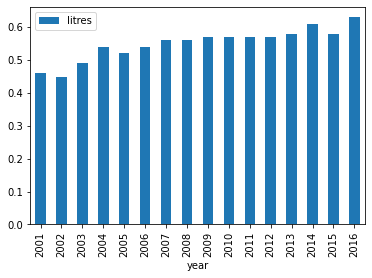

In [27]:
# and make a simple column chart with matplotlib
df.plot.bar(
    x='year',
    y='litres'
)